# IMDb 사이트 영화 리뷰 감성분석
RNN 모델을 이용해 감성분석을 해보자!

In [137]:
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb

print(tf.__version__)

2.4.1


# IMDb 데이터셋

### Dataset 불러오기

In [41]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

print('x_train : ', len(list(x_train)))
print('y_train : ', len(y_train))
print('x_testn : ', len(list(x_test)))
print('y_testn : ', len(y_test))
print('-'*50)
print(list(x_train)[:2])

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


x_train :  25000
y_train :  25000
x_testn :  25000
y_testn :  25000
--------------------------------------------------
[[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16,

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### Vocab

In [42]:
word_to_index = imdb.get_word_index()
word_to_index = {word:index+3 for word, index in word_to_index.items()}
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2
word_to_index['<UNUSED>'] = 3

index_to_word = {index:word for word, index in word_to_index.items()}
print('Number of Word : ', len(word_to_index))
print('Number of Index : ', len(index_to_word))
print("Index of 'the' : ", word_to_index['the'])
print("word of '0' : ", index_to_word[0])

Number of Word :  88588
Number of Index :  88588
Index of 'the' :  4
word of '0' :  <PAD>


# Encode & Decode

In [43]:
def encode_sentences(sentences, word_to_index=word_to_index):
    encoded_sentences = []
    
    for sentence in sentences:
        new_sentence = [word_to_index['<BOS>']]
        
        for word in sentence:
            if word in word_to_index:
                new_sentence.append(word_to_index[word])
            else:
                new_sentence.append(word_to_index['<UNK>'])
                
        encoded_sentences.append(new_sentence)
        
    return encoded_sentences

def decode_sentences(sentences, index_to_word=index_to_word):
    decoded_sentences = []
    
    for sentence in sentences:
        new_sentence = []
        
        for idx in sentence:
            if idx in index_to_word:
                new_sentence.append(index_to_word[idx])
            else:
                new_sentence.append(word_to_index[1])
                
        decoded_sentences.append(' '.join(new_sentence))
        
    return decoded_sentences

In [44]:
decode_example = decode_sentences([x_train[0]], index_to_word)
print(x_train[0])
decode_example

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


["<BOS> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

# Padding

### 문장의 최대길이 선정

Mean of sentences : 234.75892
Max of sentences :  2494
Min of sentences :  7
The 95% of Length : [598.]


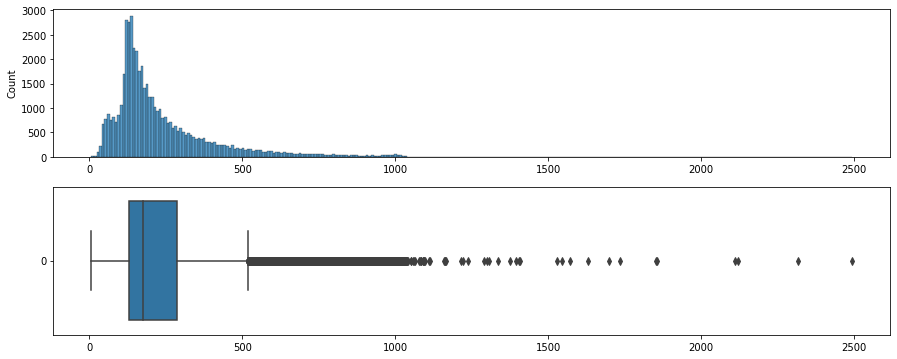

In [45]:
len_x_train = len(x_train)
dataset = list(x_train) + list(x_test)
len_sentence = np.array([len(sent) for sent in dataset])
percent = 95

print('Mean of sentences :', np.mean(len_sentence))
print('Max of sentences : ', np.max(len_sentence))
print('Min of sentences : ', np.min(len_sentence))


plt.figure(figsize=(15,6))

plt.subplot(2,1,1)
sns.histplot(len_sentence)

plt.subplot(2,1,2)
sns.boxplot(data=len_sentence, orient='h')
print(f'The {percent}% of Length :', np.percentile(len_sentence, [percent]))
plt.show()

> **최대길이 : 580**

### Padding 적용

In [46]:
padding = keras.preprocessing.sequence.pad_sequences
dataset = padding(dataset, value=word_to_index['<PAD>'], padding='pre', maxlen=580)
x_train = dataset[:x_train_len]
x_test = dataset[x_train_len:]

print(x_train.shape, x_test.shape)
print(type(x_train), type(x_test))
print(x_train[0])

(25000, 580) (25000, 580)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   

# Model

In [47]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim))
model.add(keras.layers.LSTM(units=8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


# Train

In [48]:
X_train, x_val, Y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
print('Train Shape : ', X_train.shape, Y_train.shape)
print('val Shape : ', x_val.shape, y_val.shape)

Train Shape :  (20000, 580) (20000,)
val Shape :  (5000, 580) (5000,)


In [49]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
EPOCH=20

history = model.fit(X_train, Y_train, epochs=EPOCH, batch_size=512, validation_data=(x_val, y_val),verbose=1)

Epoch 1/20
40/40 [==============================] - 11s 194ms/step - loss: 0.6920 - accuracy: 0.5584 - val_loss: 0.6824 - val_accuracy: 0.6784
Epoch 2/20
40/40 [==============================] - 7s 181ms/step - loss: 0.6581 - accuracy: 0.7365 - val_loss: 0.5649 - val_accuracy: 0.7578
Epoch 3/20
40/40 [==============================] - 7s 181ms/step - loss: 0.5063 - accuracy: 0.8198 - val_loss: 0.4391 - val_accuracy: 0.8268
Epoch 4/20
40/40 [==============================] - 7s 181ms/step - loss: 0.3834 - accuracy: 0.8693 - val_loss: 0.3912 - val_accuracy: 0.8408
Epoch 5/20
40/40 [==============================] - 7s 182ms/step - loss: 0.3015 - accuracy: 0.9034 - val_loss: 0.3695 - val_accuracy: 0.8518
Epoch 6/20
40/40 [==============================] - 7s 181ms/step - loss: 0.2539 - accuracy: 0.9173 - val_loss: 0.3755 - val_accuracy: 0.8442
Epoch 7/20
40/40 [==============================] - 7s 181ms/step - loss: 0.2252 - accuracy: 0.9272 - val_loss: 0.3713 - val_accuracy: 0.8550
Epoch

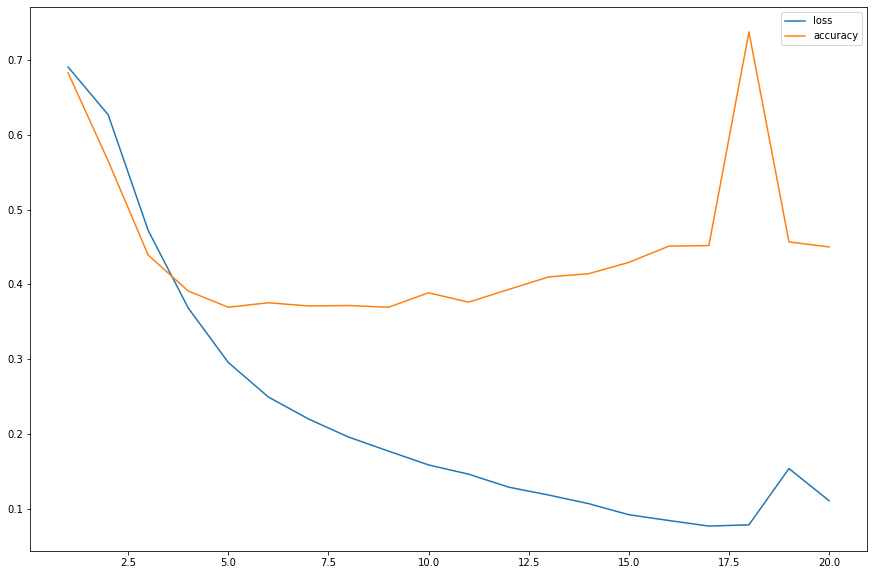

In [61]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epoch_range = range(1,EPOCH+1)

plt.figure(figsize=(15,10))
plt.plot(epoch_range, train_loss)
#plt.plot(epoch_range, train_acc)
plt.plot(epoch_range, val_loss)
#plt.plot(epoch_range, val_accuracy)

plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Evaluation

782/782 - 36s - loss: 0.4477 - accuracy: 0.8541


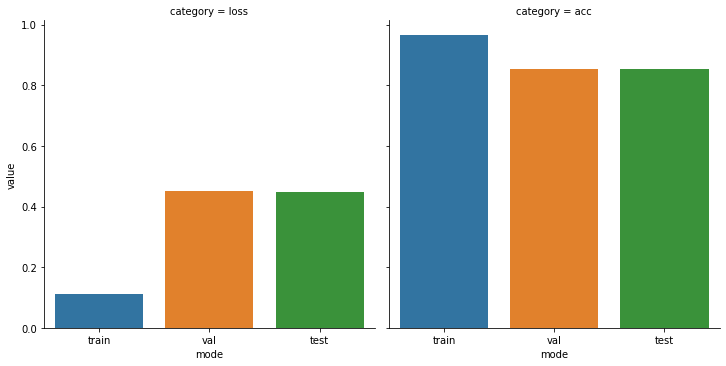

In [138]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

data = {'loss' : [train_loss[-1],  val_loss[-1], test_loss],
        'acc' : [train_acc[-1], val_acc[-1], test_acc]}

df_result = pd.DataFrame(data, index=['train', 'val', 'test']).reset_index()
df_result = df_result.rename(columns={'index' : 'mode'})
df_result = pd.melt(df_result, id_vars='mode', value_vars=['loss', 'acc'], var_name='category')
sns.catplot(x='mode', y='value', col='category', kind='bar', data=df_result)